<a href="https://colab.research.google.com/github/MikeXL/brain/blob/master/wine_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MJ LOG 0130.031118

Finnaly it meet the need for a vanilla neural net to predict the wine class based on the available features.

**Data prep**
*sklearn* does provide preprocessing and train, validation, test split

**Data exploration**
*matplot* is convenient enough for simple histogram, boxplot, trend lines, bar chart, scatter plot, 
[gallery](https://matplotlib.org/2.1.1/gallery/index.html) here to have fun

**Modeling**
*pytorch* is intuitive enough to use, with minor painful points that have to solve along the way such as 
weight reset in order to start clean, that has not been mentioned in documentation, or at least I have not seen 
rather than in forum post.Other than that it is a smooth ride.

**Validation**
Currently simply calculating the misclassification rate, not ideal. 

Next step for me, 
1. *Hyperarameter tuning* such as learning rate along with different optimization technique (L-BFGS, Adam, SGD, RMSprop etc.) 
and plot their performance against one another. Perhaps throw in different loss function too.
2. Validate model with validation dataset, along with measures like ROC, lift, gain, confusion matrix, F1, refer [here](http://scikit-learn.org/stable/modules/model_evaluation.html) from sklearn

Once that is done, then move onto attention network, autoencoder, Q network and GAN.

In [1]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu90/torch_nightly.html

Looking in links: https://download.pytorch.org/whl/nightly/cu90/torch_nightly.html
    100% |████████████████████████████████| 600.3MB 20kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x55c87b520000 @  0x7f94899db2a4 0x55c81beb6b68 0x55c81bfa292d 0x55c81beca01a 0x55c81beced72 0x55c81bec78ca 0x55c81becf24e 0x55c81bec78ca 0x55c81becf24e 0x55c81bec78ca 0x55c81becf24e 0x55c81bec78ca 0x55c81becf7d3 0x55c81bec78ca 0x55c81becf24e 0x55c81bec78ca 0x55c81becf24e 0x55c81beced72 0x55c81beced72 0x55c81bec78ca 0x55c81becf7d3 0x55c81beced72 0x55c81bec78ca 0x55c81becf7d3 0x55c81bec78ca 0x55c81becf7d3 0x55c81bec78ca 0x55c81becf24e 0x55c81bec78ca 0x55c81bec71e9 0x55c81bef7bdf


In [0]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

In [0]:
from sklearn import datasets
wine = datasets.load_wine()


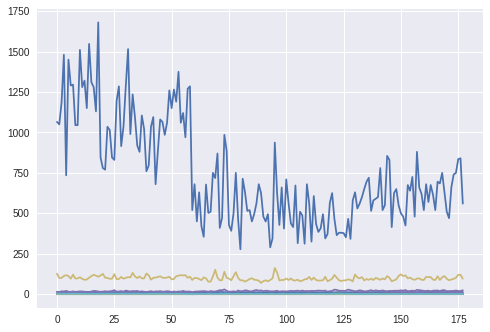

In [13]:
plt.plot(wine.data)

In [14]:
wine.feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

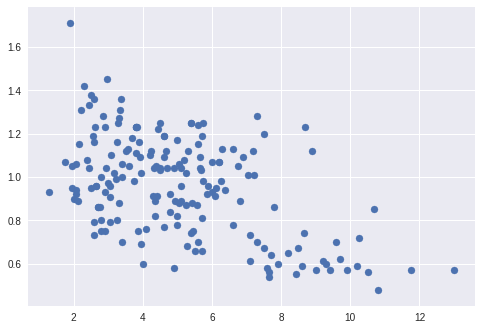

In [15]:
plt.scatter(wine.data[:, -4], wine.data[:, -3])

{'boxes': [<matplotlib.lines.Line2D at 0x7fe20267e910>],
 'caps': [<matplotlib.lines.Line2D at 0x7fe202689150>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe202689c90>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fe2026898d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fe20278d290>,
  <matplotlib.lines.Line2D at 0x7fe20267ed10>]}

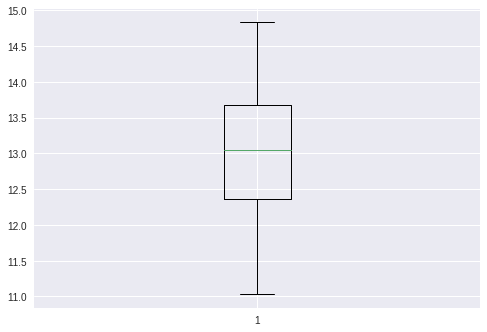

In [16]:
plt.boxplot(wine.data[:, 0])

In [17]:
print wine.DESCR

Wine Data Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- 1) Alcohol
 		- 2) Malic acid
 		- 3) Ash
		- 4) Alcalinity of ash  
 		- 5) Magnesium
		- 6) Total phenols
 		- 7) Flavanoids
 		- 8) Nonflavanoid phenols
 		- 9) Proanthocyanins
		- 10)Color intensity
 		- 11)Hue
 		- 12)OD280/OD315 of diluted wines
 		- 13)Proline
        	- class:
                - class_0
                - class_1
                - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash: 

In [0]:
import sklearn
wine.data = sklearn.preprocessing.scale(wine.data)   ## scale for prior feeding into nnet

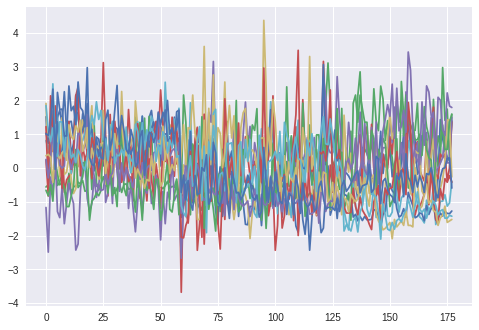

In [20]:
plt.plot(wine.data)

In [0]:
x = torch.from_numpy(wine.data).float()       ## features
y = torch.from_numpy(wine.target).long()      ## target

In [0]:
model = nn.Sequential(
  nn.Linear(13,24),
  nn.ReLU(),
  nn.Linear(24,12),
  nn.ReLU(),
  nn.Linear(12,3),
  nn.Softmax(1)
)

In [0]:
## reset the nn weight to start clean, and retrain
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [0]:
def score(model, x, y):
  model.eval()
  out=model(x)
  _, pred = torch.max(out, 1)

  print "Misclassified %s/%s" % ((y.size(0) - (pred.data==y.data).sum(0)), y.size(0))


In [0]:
EPOCH = 500
lr = .1
lf = nn.CrossEntropyLoss()

In [0]:
# train L-BFGS
def fit_lbfgs(model, optim, Floss, epoch):
  losses = []
  for _ in range(epoch):
    def closure():
      optim.zero_grad()
      yhat = model(x)
      loss = Floss(yhat, y)
      losses.append(loss.item())
      loss.backward()
      return loss
    optim.step(closure)
  return losses


# train Adam, SGD, RMSprop
def fit(model, optim, Floss, epoch):
  losses = []
  for _ in range(epoch):
    optim.zero_grad()
    yhat = model(x)
    loss = Floss(yhat, y)
    losses.append(loss.item())
    loss.backward()
    optim.step()
  return losses


## might need this code at somepoint to plug in
## for validation
## with torch.no_grad():
##  pred = model(x))
##  l = lf(pred, y)

In [44]:

for lr in [1, .1, .01, .001]:
  optim_lbfgs   = torch.optim.LBFGS(model.parameters(), lr=lr)
  optim_adam    = torch.optim.Adam(model.parameters(), lr=lr)
  optim_sgd     = torch.optim.SGD(model.parameters(), lr=lr)
  optim_rmsprop = torch.optim.RMSprop(model.parameters(), lr=lr)

  idx = int(np.log10(lr*1000))

  model.apply(weight_reset)
  model.train()
  loss_lbfgs[idx] = fit_lbfgs(model, optim_lbfgs, lf, EPOCH)
  score(model, x, y)

  model.apply(weight_reset)
  model.train()
  loss_adam[idx] = fit(model, optim_adam, lf, EPOCH)
  score(model, x, y)

  model.apply(weight_reset)
  model.train()
  loss_sgd[idx] = fit(model, optim_sgd, lf, EPOCH)
  score(model, x, y)

  model.apply(weight_reset)
  model.train()
  loss_rmsprop[idx] = fit(model, optim_rmsprop, lf, EPOCH)
  score(model, x, y)

Misclassified tensor(107)/178
Misclassified tensor(119)/178
Misclassified tensor(0)/178
Misclassified tensor(107)/178
Misclassified tensor(0)/178
Misclassified tensor(0)/178
Misclassified tensor(0)/178
Misclassified tensor(107)/178
Misclassified tensor(68)/178
Misclassified tensor(0)/178
Misclassified tensor(71)/178
Misclassified tensor(0)/178
Misclassified tensor(1)/178
Misclassified tensor(0)/178
Misclassified tensor(113)/178
Misclassified tensor(0)/178


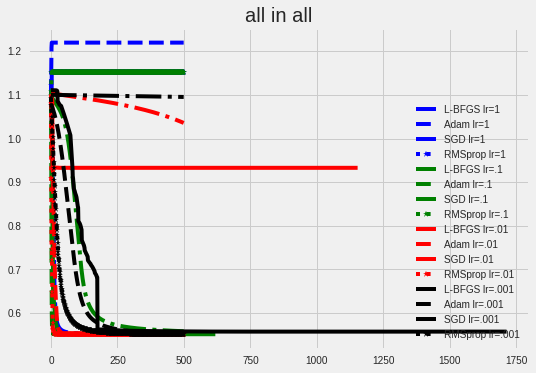

In [103]:
plt.plot(loss_lbfgs[3], 'b-', label="L-BFGS lr=1")
plt.plot(loss_adam[3], 'b--', label="Adam lr=1")
plt.plot(loss_sgd[3], 'b-.', label="SGD lr=1")
plt.plot(loss_rmsprop[3], 'b:*', label="RMSprop lr=1")
plt.plot(loss_lbfgs[2], 'g-', label="L-BFGS lr=.1")
plt.plot(loss_adam[2], 'g--', label="Adam lr=.1")
plt.plot(loss_sgd[2], 'g-.', label="SGD lr=.1")
plt.plot(loss_rmsprop[2], 'g:*', label="RMSprop lr=.1")
plt.plot(loss_lbfgs[1], 'r-', label="L-BFGS lr=.01")
plt.plot(loss_adam[1], 'r--', label="Adam lr=.01")
plt.plot(loss_sgd[1], 'r-.', label="SGD lr=.01")
plt.plot(loss_rmsprop[1], 'r:*', label="RMSprop lr=.01")
plt.plot(loss_lbfgs[0], 'k-', label="L-BFGS lr=.001")
plt.plot(loss_adam[0], 'k--', label="Adam lr=.001")
plt.plot(loss_sgd[0], 'k-.', label="SGD lr=.001")
plt.plot(loss_rmsprop[0], 'k:*', label="RMSprop lr=.001")
plt.legend(loc="lower right")
plt.title("all in all")
plt.style.use('fivethirtyeight')

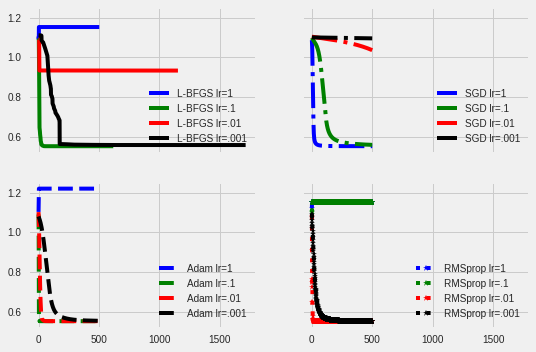

In [126]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
plt.style.use('fivethirtyeight')

axs[0,0].plot(loss_lbfgs[3], 'b-', label="L-BFGS lr=1")
axs[0,0].plot(loss_lbfgs[2], 'g-', label="L-BFGS lr=.1")
axs[0,0].plot(loss_lbfgs[1], 'r-', label="L-BFGS lr=.01")
axs[0,0].plot(loss_lbfgs[0], 'k-', label="L-BFGS lr=.001")
axs[0,0].legend(loc="lower right")
#axs[0,0].text("L-BFGS")



axs[1,0].plot(loss_adam[3], 'b--', label="Adam lr=1")
axs[1,0].plot(loss_adam[2], 'g--', label="Adam lr=.1")
axs[1,0].plot(loss_adam[1], 'r--', label="Adam lr=.01")
axs[1,0].plot(loss_adam[0], 'k--', label="Adam lr=.001")
axs[1,0].legend(loc="lower right")
#axs[0,1].title("Adam")

axs[0,1].plot(loss_sgd[3], 'b-.', label="SGD lr=1")
axs[0,1].plot(loss_sgd[2], 'g-.', label="SGD lr=.1")
axs[0,1].plot(loss_sgd[1], 'r-.', label="SGD lr=.01")
axs[0,1].plot(loss_sgd[0], 'k-.', label="SGD lr=.001")
axs[0,1].legend(loc="lower right")
#axs[1,0].title("SGD")

axs[1,1].plot(loss_rmsprop[3], 'b:*', label="RMSprop lr=1")
axs[1,1].plot(loss_rmsprop[2], 'g:*', label="RMSprop lr=.1")
axs[1,1].plot(loss_rmsprop[1], 'r:*', label="RMSprop lr=.01")
axs[1,1].plot(loss_rmsprop[0], 'k:*', label="RMSprop lr=.001")
axs[1,1].legend(loc="lower right")
#axs[1,1].title("RMSprop")


#plt.tight_layout()
#plt.show()

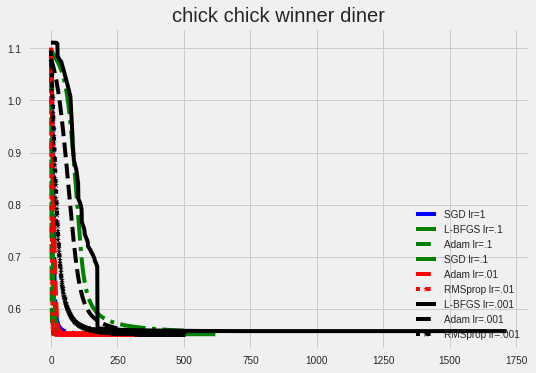

In [132]:
#plt.plot(loss_lbfgs[3], 'b-', label="L-BFGS lr=1")
#plt.plot(loss_adam[3], 'b--', label="Adam lr=1")
plt.plot(loss_sgd[3], 'b-.', label="SGD lr=1")
#plt.plot(loss_rmsprop[3], 'b:*', label="RMSprop lr=1")
plt.plot(loss_lbfgs[2], 'g-', label="L-BFGS lr=.1")
plt.plot(loss_adam[2], 'g--', label="Adam lr=.1")
plt.plot(loss_sgd[2], 'g-.', label="SGD lr=.1")
#plt.plot(loss_rmsprop[2], 'g:*', label="RMSprop lr=.1")
#plt.plot(loss_lbfgs[1], 'r-', label="L-BFGS lr=.01")
plt.plot(loss_adam[1], 'r--', label="Adam lr=.01")
#plt.plot(loss_sgd[1], 'r-.', label="SGD lr=.01")
plt.plot(loss_rmsprop[1], 'r:*', label="RMSprop lr=.01")
plt.plot(loss_lbfgs[0], 'k-', label="L-BFGS lr=.001")
plt.plot(loss_adam[0], 'k--', label="Adam lr=.001")
#plt.plot(loss_sgd[0], 'k-.', label="SGD lr=.001")
plt.plot(loss_rmsprop[0], 'k:*', label="RMSprop lr=.001")
plt.legend(loc="lower right")
plt.title("chick chick winner diner")
plt.style.use('fivethirtyeight')

In [56]:
print optim_lbfgs.state_dict
print optim_adam.state_dict
print optim_sgd.state_dict
print optim_rmsprop.state_dict

<bound method LBFGS.state_dict of LBFGS (
Parameter Group 0
    history_size: 100
    line_search_fn: None
    lr: 0.001
    max_eval: 25
    max_iter: 20
    tolerance_change: 1e-09
    tolerance_grad: 1e-05
)>
<bound method Adam.state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)>
<bound method SGD.state_dict of SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)>
<bound method RMSprop.state_dict of RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 0
)>


In [0]:
print (optim_lbfgs.param_groups[0].items())[4]
print (optim_adam.param_groups[0].items())[4]
print (optim_sgd.param_groups[0].items())[4]
print (optim_rmsprop.param_groups[0].items())[4]